# Polynomial Regression

In [27]:
# You'll need PyPlot for this one, so see if you have it installed 
using Pkg
Pkg.status()

Status `~/.julia/environments/v1.10/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [e2554f3b] Clp v1.0.3
  [a93c6f00] DataFrames v1.6.1
  [ffbed154] DocStringExtensions v0.9.3
⌃ [e2685f51] ECOS v1.1.1
⌃ [59287772] Formatting v0.4.2
  [60bf3e95] GLPK v1.1.3
  [2e9cd046] Gurobi v1.2.1
⌃ [87dc4568] HiGHS v1.8.0
  [7073ff75] IJulia v1.24.2
  [c601a237] Interact v0.10.5
⌃ [b6b21f68] Ipopt v1.6.0
⌃ [4076af6c] JuMP v1.18.1
  [86f7a689] NamedArrays v0.10.0
⌃ [91a5bcdd] Plots v1.40.0
  [d330b81b] PyPlot v2.11.2
  [c946c3f1] SCS v2.0.0
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [28]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5, 5, 6, 7.2, 5.5,  4, 3.2, 5]
;


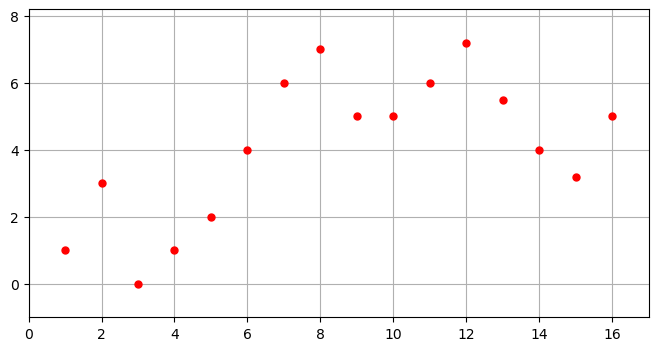

In [29]:
using PyPlot 
function plotxypoints(x,y)

    minx = minimum(x)
    maxx = maximum(x)
    miny = minimum(y)
    maxy = maximum(y)    
    figure(figsize=(8,4))
    plot(x,y,"r.", markersize=10)
    axis([minx-1,maxx+1,miny-1,maxy+1])
    grid("True")
    # Only need this in vscode?
    display(gcf())
end
;
plotxypoints(x,y)

In [30]:
# Fit the data using a function of the form y = f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}

# Order of polynomial used for fitting
k = 4

# Create the A matrix (where each row corresponds to one observation x_i and each column is an x^k term)
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end
A

16×5 Matrix{Float64}:
     1.0     1.0    1.0   1.0  1.0
    16.0     8.0    4.0   2.0  1.0
    81.0    27.0    9.0   3.0  1.0
   256.0    64.0   16.0   4.0  1.0
   625.0   125.0   25.0   5.0  1.0
  1296.0   216.0   36.0   6.0  1.0
  2401.0   343.0   49.0   7.0  1.0
  4096.0   512.0   64.0   8.0  1.0
  6561.0   729.0   81.0   9.0  1.0
 10000.0  1000.0  100.0  10.0  1.0
 14641.0  1331.0  121.0  11.0  1.0
 20736.0  1728.0  144.0  12.0  1.0
 28561.0  2197.0  169.0  13.0  1.0
 38416.0  2744.0  196.0  14.0  1.0
 50625.0  3375.0  225.0  15.0  1.0
 65536.0  4096.0  256.0  16.0  1.0

In [31]:
# Solve the LEAST SQUARES polynomial fit

using JuMP, HiGHS
m = Model(HiGHS.Optimizer)

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
# @objective(m, Min, dot(y-A*u,y-A*u) )

optimize!(m)
uopt = value.(u)
println(termination_status(m))
println("The objective value is ", objective_value(m))
println(uopt)

# Let's check Julia LinearAlgebra (probably more numerically stable and faster)
api = pinv(A)
u2 = pinv(A)*y 
println(u2)

# And can even do fancy \ operator 
u3 = A \ y
println(u3)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Iteration, Runtime, ObjVal, NullspaceDim
0, 0.000457, 335.330000, 5
3, 0.000554, 17.164392, 5
Model   status      : Optimal
Objective value     :  1.7164392266e+01
HiGHS run time      :          0.00
OPTIMAL
The objective value is 17.16439226611209
[0.002320865086924293, -0.08461679037332698, 0.9697320046434447, -3.351588258445381, 4.320673076919955]
[0.002320865086925453, -0.08461679037336915, 0.969732004643961, -3.3515882584477703, 4.320673076923075]
[0.002320865086925458, -0.08461679037336926, 0.9697320046439619, -3.3515882584477747, 4.3206730769230814]


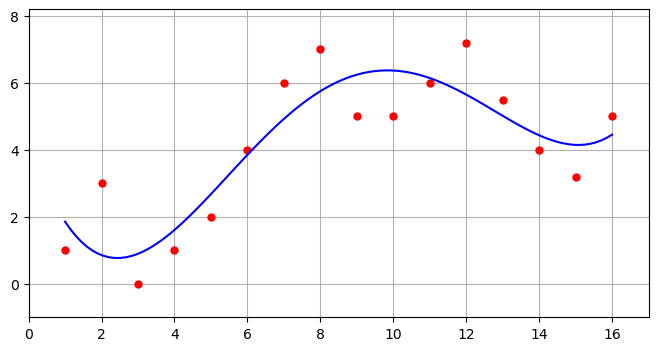

In [32]:
using PyPlot, LinearAlgebra
function plotwregsol(x,y,usol)

    minx = minimum(x)
    maxx = maximum(x)
    miny = minimum(y)
    maxy = maximum(y)   

    # Make (npts,k+1) matrix containing polynomial term values at plot points.  Fancy matrix stuff.
    npts = 100
    xfine = range(minx,stop=maxx,length=npts)
    ffine = ones(npts)
    for j = 1:k
        ffine = [ffine.*xfine ones(npts)]
    end

    # Compute the estimate values
    yfine = ffine * usol

    # Plot 'em
    figure(figsize=(8,4))
    plot(x,y,"r.", markersize=10)
    plot( xfine, yfine, "b-")

    axis([minx-1,maxx+1,miny-1,maxy+1])

    grid()
    display(gcf())
end
plotwregsol(x,y,uopt)

In [33]:
# Solve the L_1 NORM polynomial fit. 
#  We learned how to do this already
using JuMP, HiGHS

m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, u[1:k+1])
@variable(m, t[1:n])
@constraint(m, y-A*u .<= t)
@constraint(m, A*u-y .<= t)
@objective(m, Min, sum(t))

optimize!(m)
uopt_l1 = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_l1)

OPTIMAL
12.167132867132857
[0.0033022533022532973, -0.11600621600621584, 1.2794483294483279, -4.2418026418026376, 4.0750582750582725]


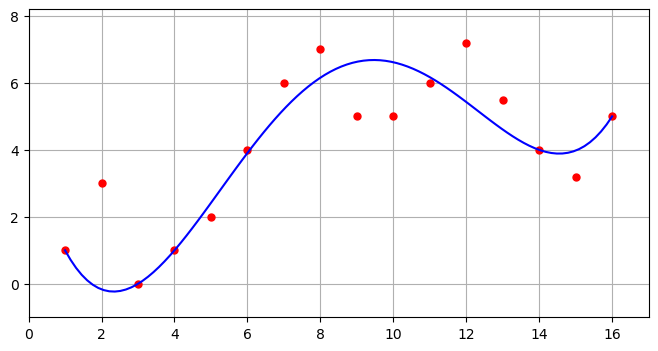

In [34]:
plotwregsol(x,y,uopt_l1)

In [35]:
# Let's also do infinity norm 

m = Model(HiGHS.Optimizer)
set_silent(m)

@variable(m, u[1:k+1])
@variable(m, z)
@constraint(m, y-A*u .<= z*ones(n))
@constraint(m, A*u-y .<= z*ones(n))
@objective(m, Min, z)

optimize!(m)
uopt_linfinity = value.(u)
println(termination_status(m))
println(objective_value(m))
println(uopt_linfinity)

OPTIMAL
1.458156028368797
[0.0014302600472813878, -0.058058088483622206, 0.728904086457293, -2.718071597433339, 4.503951367781184]


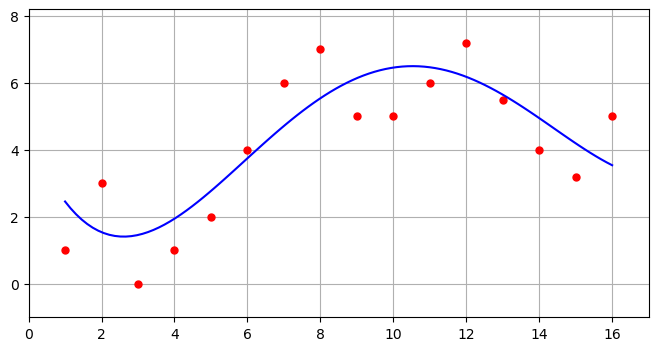

In [36]:
plotwregsol(x,y,uopt_linfinity)